# Getting to grips with merges/splits

Some experimentation with merges/splits to understand how it is represented in the MCS database. 

1. I think there are two related areas. Merging/splitting of clouds at one track point, merging splitting of an MCS track (see para 1-2 and 3 respectively below). This is investigated in Analysis 1 and 2 below.
2. Produce some basic stats: number of MCS merges/splits etc.

For 1., on merging/splitting of clouds at one track point, the main point is that all clouds that will/have merge/split from the MCS are recorded. I did not understand this at first. MCS merge/splits are handled similarly. The cloudnumber of the merged/split cloud is recorded, and this can be used to locate the MCS track at the next/previous timestep.

For 2., there are some basic stats below. About 1/3 either merge or split, with 55% doing at least one (45% "natural" MCS tracks).

* TODO: tidy up code. Animations for merge/split of clouds at one track point. Helper functions to work out e.g. DAG of MCS tracks.
* 10/6/22: Initial work on getting the basics working.

## Email from Zhe Feng on merge/splitting in the database (6/5/22):

For small clouds that merge/split with MCSs, I already included them in the pixel-level files as part of the parent MCS. That is, the cloudtracknumber/pcptracknumber masks include the mergers/splits.  You can take a look at the differences between those two variables and merge_tracknumbers/split_tracknumbers to find those.

In addition, in the track stats files, merge_cloudnumber/split_cloudnumber record the cloud numbers that merge/split with an MCS at a given time (the 3rd dimension “mergers”).  And the merge_ccs_area/split_ccs_area record the size of those clouds.  If you add them all up at a given time, that should be the total cloud area of a given MCS.

If an MCS splits in two, but each of them satisfies the MCS definition after they split, they will remain two separate tracks. Similar treatments are done for mergers.  I think these MCSs have more complex history and should be analyzed separately from those that evolve more “naturally”, e.g., initiate on its own and did not end as a merger.  On page 6 of the MCS documentation, I listed two methods to separate these tracks, I think the first method (using start_split_cloudnumber/end_merge_cloudnumber) is easier to do.

## Analysis 1 (merge/split clouds)

In [1]:
import datetime as dt
import itertools
from pathlib import Path

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import xarray as xr

from mcs_prime import McsTracks, PATHS
from mcs_prime.util import update_progress
%matplotlib inline

Load all tracks from 2000/6-2020/12

In [2]:
tracks = tracks = McsTracks.load(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                                 PATHS['pixeldir'])
tracks

McsTracks[2019-01-01 00:30:00, 2019-12-31 22:30:00, ntracks=32843]

In [5]:
time = dt.datetime(2019, 6, 5, 0, 30)
pdtime = pd.Timestamp(time)

In [6]:
ts = tracks.tracks_at_time(time)
frame = ts.pixel_data.get_frame(time)
tmask = (ts.dstracks.base_time == pdtime).values

In [7]:
pixel_precip = frame.dspixel.precipitation.isel(time=0)

In [8]:
frame.dspixel

<xarray.Dataset>
Dimensions:                        (time: 1, lat: 1200, lon: 3600)
Coordinates:
  * time                           (time) datetime64[ns] 2019-06-05T00:30:00....
  * lat                            (lat) float32 -59.95 -59.85 ... 59.85 59.95
  * lon                            (lon) float32 -179.9 -179.9 ... 179.9 179.9
Data variables:
    base_time                      (time) datetime64[ns] ...
    longitude                      (lat, lon) float32 ...
    latitude                       (lat, lon) float32 ...
    tb                             (time, lat, lon) float32 ...
    precipitation                  (time, lat, lon) float32 ...
    cloudtype                      (time, lat, lon) float64 ...
    cloudnumber                    (time, lat, lon) float64 ...
    split_tracknumbers             (time, lat, lon) float64 ...
    merge_tracknumbers             (time, lat, lon) float64 ...
    cloudtracknumber_nomergesplit  (time, lat, lon) float64 ...
    cloudtracknumber               (time, lat, lon) float64 ...
    pcptracknumber                 (time, lat, lon) float64 ...
Attributes:
    Title:                     Robust MCS pixel-level tracking data
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Fri Mar 18 16:50:12 2022
    startdate:                 20190101.0000
    enddate:                   20200101.0000
    precipitation_datasource:  imerg
    mcs_tb_area_thresh:        40000
    mcs_tb_duration_thresh:    4
    mcs_pf_majoraxis_thresh:   100
    mcs_pf_durationthresh:     4

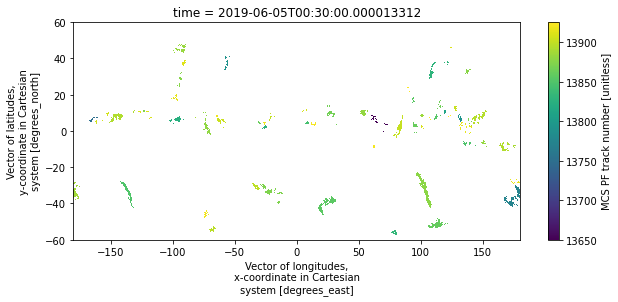

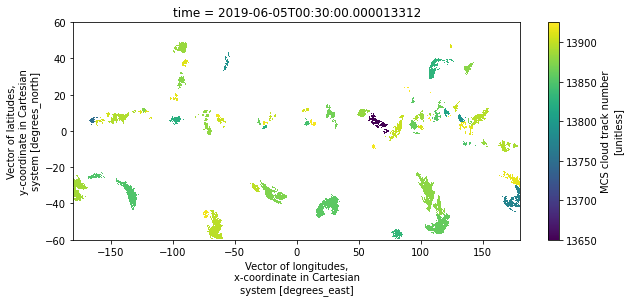

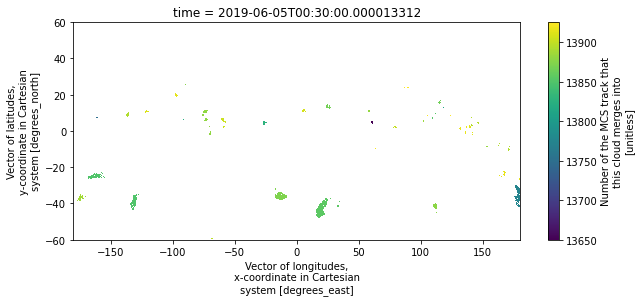

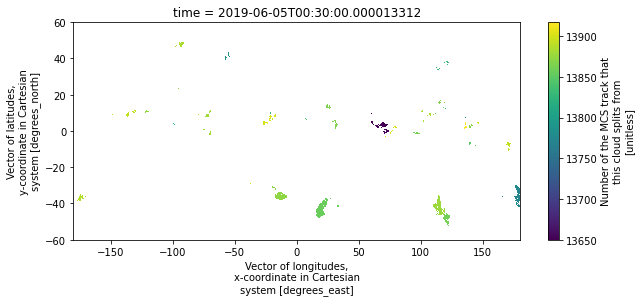

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 4))
frame.dspixel.pcptracknumber.plot(ax=ax);

fig, ax = plt.subplots()
fig.set_size_inches((10, 4))
frame.dspixel.cloudtracknumber.plot(ax=ax);

fig, ax = plt.subplots()
fig.set_size_inches((10, 4))
frame.dspixel.merge_tracknumbers.plot(ax=ax);

fig, ax = plt.subplots()
fig.set_size_inches((10, 4))
frame.dspixel.split_tracknumbers.plot(ax=ax);

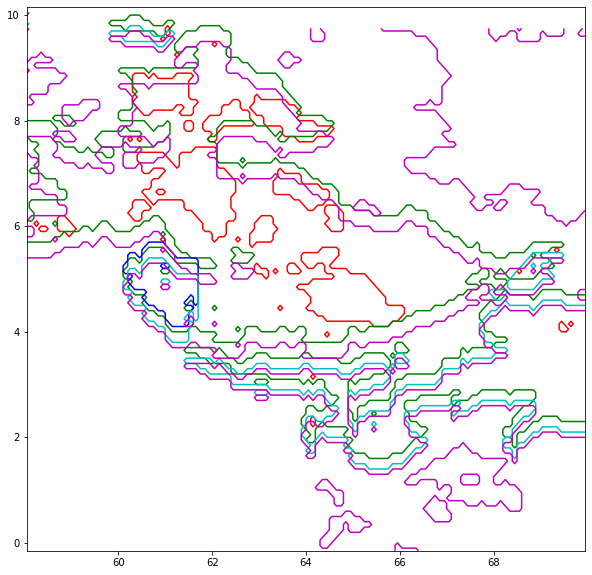

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
subds = frame.dspixel.sel(lat=slice(0, 10), lon=slice(58, 70)).isel(time=0)

def contour(ax, f, c, offset=0):
    ax.contour(f.lon, f.lat + offset, f > 0, levels=[0.5], colors=[c])
    
contour(ax, subds.pcptracknumber, 'r')
contour(ax, subds.cloudtracknumber, 'g', 0.1)
contour(ax, subds.merge_tracknumbers, 'b', 0.2)
contour(ax, subds.split_tracknumbers, 'c', -0.1)
contour(ax, subds.cloudnumber, 'm', -0.2)    

#(subds.pcptracknumber > 0).plot.contour(ax=ax, levels=[0.5], colors=['r']);
#(subds.cloudtracknumber > 0).plot.contour(ax=ax, levels=[0.5], colors=['g']);
#(subds.merge_tracknumbers > 0).plot.contour(ax=ax, levels=[0.5], colors=['b']);
#(subds.split_tracknumbers > 0).plot.contour(ax=ax, levels=[0.5], colors=['c']);
#(subds.cloudnumber > 0).plot.contour(ax=ax, levels=[0.5], colors=['m']);

What's going on here? The different fields are shown by different colours, and offset so they don't overlap. Hard to make sense of though. So find the track that this belongs to, and see if I can use the info from that to make sense of the above...

In [ ]:
f = subds.cloudnumber
print(np.unique(f.values))
t = ts.dstracks.isel(tracks=((ts.dstracks.base_time == pdtime) & (ts.dstracks.cloudnumber == 60)).any(axis=1))
print(t.base_time.values[0, 17])
print(t.cloudnumber.values[0, 17])
print(t.meanlon.values[0, 17], t.meanlat.values[0, 17])
print(t.merge_cloudnumber.values[0, 17])
print(t.split_cloudnumber.values[0, 17])
print(np.unique(subds.merge_tracknumbers.values))

In [ ]:
t.tracks

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))

contour(ax, f == 60, 'g')
contour(ax, f == 142, 'b')
contour(ax, f == 164, 'r')
contour(ax, f == 404, 'c')

contour(ax, subds.merge_tracknumbers == 299, 'k', 0.1)
contour(ax, subds.split_tracknumbers == 299, 'k', -0.1)
contour(ax, subds.cloudtracknumber == 299, 'k', -0.3)



As the above figure, but easier to make out what's going on. Colours show the clouds from the raw cloudnumber field, as taken from the track. Green shows the main cloud; red, blue and cyan show the mergers/splits (N.B. all are both of these). Black offset up shows the same thing but in the pixel data from merg_tracknumbers field, ditto black offset down. Black offset down by 0.3 shows all cloud fields associated with track. N.B. number is pixel data is 299; number in tracks is 298; I believe this is because I re-index track data on load.

In [ ]:
next_frame = ts.pixel_data.get_frame(time + dt.timedelta(hours=1))
next_subds = next_frame.dspixel.sel(lat=slice(0, 10), lon=slice(58, 70)).isel(time=0)
print(t.base_time.values[0, 18])
print(t.cloudnumber.values[0, 18])
print(t.meanlon.values[0, 18], t.meanlat.values[0, 18])
print(t.merge_cloudnumber.values[0, 18])
print(t.split_cloudnumber.values[0, 18])



In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))

f = next_subds.cloudnumber
contour(ax, f == 44, 'g')
contour(ax, f == 138, 'b')
contour(ax, f == 193, 'r')


contour(ax, next_subds.merge_tracknumbers == 299, 'k', 0.1)
contour(ax, next_subds.split_tracknumbers == 299, 'k', -0.1)
contour(ax, next_subds.cloudtracknumber == 299, 'k', -0.3)



In [ ]:
next_frame = ts.pixel_data.get_frame(time + dt.timedelta(hours=2))
next_subds = next_frame.dspixel.sel(lat=slice(0, 10), lon=slice(58, 70)).isel(time=0)
print(t.base_time.values[0, 19])
print(t.cloudnumber.values[0, 19])
print(t.meanlon.values[0, 19], t.meanlat.values[0, 19])
print(t.merge_cloudnumber.values[0, 19])
print(t.split_cloudnumber.values[0, 19])



In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))

f = next_subds.cloudnumber
contour(ax, f == 50, 'g')
contour(ax, f == 134, 'b')
contour(ax, f == 299, 'r')
contour(ax, f == 685, 'c')


contour(ax, next_subds.merge_tracknumbers == 299, 'k', 0.1)
contour(ax, next_subds.split_tracknumbers == 299, 'k', -0.1)
contour(ax, next_subds.cloudtracknumber == 299, 'k', -0.3)



In [ ]:
next_frame = ts.pixel_data.get_frame(time + dt.timedelta(hours=3))
next_subds = next_frame.dspixel.sel(lat=slice(0, 10), lon=slice(58, 70)).isel(time=0)
print(t.base_time.values[0, 20])
print(t.cloudnumber.values[0, 20])
print(t.meanlon.values[0, 20], t.meanlat.values[0, 20])
print(t.merge_cloudnumber.values[0, 20])
print(t.split_cloudnumber.values[0, 20])



In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))

f = next_subds.cloudnumber
contour(ax, f == 46, 'g')
contour(ax, f == 193, 'b')
contour(ax, f == 446, 'r')

contour(ax, next_subds.merge_tracknumbers == 299, 'k', 0.1)
contour(ax, next_subds.split_tracknumbers == 299, 'k', -0.1)
contour(ax, next_subds.cloudtracknumber == 299, 'k', -0.3)



OK, looking at the above figs, you can see the main (green) area progressing. If a cloud splits from that, it is added to the splits field, and if a cloud will merge with it, the merges field. I will make a nice animation of this at some point now that I better understand what's happening.

## Analysis 2 (merge/split of MCS)

From PyFLEXTRKR docs (method 1 as suggested):

1. start_split_cloudnumber > 0 means track start as a split
2. end_merge_cloudnumber > 0 means track end as a merger


In [ ]:
ts.dstracks.start_split_cloudnumber

In [ ]:
ts.dstracks.end_merge_cloudnumber

### Stats on how many MCS splits/merges/either

Roughly 1/3 start with a split, 1/3 end with a merge, or 55% have at least one.

In [ ]:
ntracks = len(tracks.dstracks.tracks)

print('start split:', (tracks.dstracks.start_split_cloudnumber > 0).sum().values.item() / ntracks)
print('end merge  :', (tracks.dstracks.end_merge_cloudnumber > 0).sum().values.item() / ntracks)
print('either     :', ((tracks.dstracks.start_split_cloudnumber > 0).values | (tracks.dstracks.end_merge_cloudnumber > 0).values).sum() / ntracks)

### Linking split track to previous

How can I find the previous/next MCS? Should be able to use the cloudnumber to do so...

In [ ]:
ts.dstracks.isel(tracks=ts.dstracks.start_split_cloudnumber > 0).tracks

In [ ]:
t = ts.get_track(249)

In [ ]:
((tracks.dstracks.cloudnumber == 6) & (tracks.dstracks.base_time == t.base_time[0])).sum()

In [ ]:
((tracks.dstracks.split_cloudnumber == 6).any(axis=2) & (tracks.dstracks.base_time == t.base_time[0] - int(3600e9))).sum()

In [ ]:
for trackid in ts.dstracks.tracks.values:
    t = ts.get_track(trackid)
    if t.dstrack.start_split_cloudnumber > 0:
        print(trackid)
        sscn = t.dstrack.start_split_cloudnumber.values.item()
        print(((tracks.dstracks.cloudnumber == sscn) & (tracks.dstracks.base_time == t.base_time[0] - int(3600e9))).sum().values.item())

In [ ]:
t = ts.get_track(249)
print(t.dstrack.start_split_cloudnumber)
print(t.cloudnumber)

In [ ]:

time = dt.datetime(2019, 1, 3, 15, 30)
f0 = ts.pixel_data.get_frame(time - dt.timedelta(hours=1))
f1 = ts.pixel_data.get_frame(time)
subds0 = f0.dspixel.sel(lat=slice(0, 20), lon=slice(-150, -100)).isel(time=0)
subds1 = f1.dspixel.sel(lat=slice(0, 20), lon=slice(-150, -100)).isel(time=0)

fig, ax = plt.subplots()

contour(ax, subds0.cloudnumber == 6, 'r')
contour(ax, subds1.cloudnumber == 53, 'g')


In [ ]:
t = ts.get_track(285)
time = pd.Timestamp(t.base_time[0]).to_pydatetime()
lon = t.meanlon[0]
lat = t.meanlat[0]

f0 = ts.pixel_data.get_frame(time - dt.timedelta(hours=1))
f1 = ts.pixel_data.get_frame(time)
subds0 = f0.dspixel.sel(lat=slice(lat - 10, lat + 10), lon=slice(lon - 10, lon + 10)).isel(time=0)
subds1 = f1.dspixel.sel(lat=slice(lat - 10, lat + 10), lon=slice(lon - 10, lon + 10)).isel(time=0)

fig, ax = plt.subplots()

contour(ax, subds0.cloudnumber == t.dstrack.start_split_cloudnumber, 'r')
contour(ax, subds1.cloudnumber == t.cloudnumber[0], 'g')

In [ ]:
for trackid in ts.dstracks.isel(tracks=ts.dstracks.start_split_cloudnumber > 0).tracks:
    t = ts.get_track(trackid)
    # print(t)
    time = pd.Timestamp(t.base_time[0]).to_pydatetime()
    lon = t.meanlon[0]
    lat = t.meanlat[0]

    f0 = ts.pixel_data.get_frame(time - dt.timedelta(hours=1))
    f1 = ts.pixel_data.get_frame(time)
    subds0 = f0.dspixel.sel(lat=slice(lat - 10, lat + 10), lon=slice(lon - 10, lon + 10)).isel(time=0)
    subds1 = f1.dspixel.sel(lat=slice(lat - 10, lat + 10), lon=slice(lon - 10, lon + 10)).isel(time=0)

    fig, ax = plt.subplots()

    contour(ax, subds0.cloudnumber == t.dstrack.start_split_cloudnumber, 'r')
    contour(ax, subds1.cloudnumber == t.cloudnumber[0], 'g')

This is looking to me like it makes sense. The start_split_cloudnumber refers to the previous timestep (red) and is the parent of a (smaller, split) MCS. I should be able to work out what the parent track is too, and progress it forward in time. 

BUG: Not reassigning t so assert is always true. No longer works if t reassigned.

This is how you link it to the previous track (first 1000 checked):

In [ ]:
for trackid in tracks.dstracks.isel(tracks=tracks.dstracks.start_split_cloudnumber > 0).tracks.values[:1000]:
    sscn = t.dstrack.start_split_cloudnumber.values.item()
    found_prev_tracks = ((tracks.dstracks.cloudnumber == sscn) & (tracks.dstracks.base_time == t.base_time[0] - int(3600e9))).sum().values.item()
    assert found_prev_tracks == 1
    # print(trackid, ((tracks.dstracks.cloudnumber == sscn) & (tracks.dstracks.base_time == t.base_time[0] - int(3600e9))).sum().values.item())

Same thing works for end merge tracks.

In [ ]:
for trackid in tracks.dstracks.isel(tracks=tracks.dstracks.end_merge_cloudnumber > 0).tracks.values[:1000]:
    emcn = t.dstrack.end_merge_cloudnumber.values.item()
    found_next_tracks = ((tracks.dstracks.cloudnumber == emcn) & (tracks.dstracks.base_time == t.base_time[0] + int(3600e9))).sum().values.item()
    assert found_next_tracks == 1